# A-Scan Prediction using Machine Learning

In this notebook, we aim to predict the `A-scan` for a specifc gprMax scenario based on the choice on `parameters` input by the user. For this purpose, we wish to train a Machine Learning model by feeding as inputs -

1) The parameters corresponding to the gprMax scenario
2) The resultant A-scans

We have already generated `5000` output models for the simplest gprMax scenario - a metal cylinder buried in a a dielectric medium. Each of these models is built using randomly generated parameters, which were saved along with their corresponding output A-scans.

The ML model would be `trained on pairs of input data arrays` (i.e. model parameters, A-scans). We test the performance of popular regression algorithms such as `Random Forest`, `XGBoost`, etc. We also Note that an ML model trained for a specific scenario can only be used to predict A-scans for similar scenarios.

Additionally, to increase the efficiency of the ML algorithm, we compress the A-scans using suitable algorithms (like `PCA` or `TruncatedSVD`) instead of directly feeding them to the ML model. It is observed that the A-scans can effectively be represented using much lesser number of components without any significant loss in signal quality. 

This notebook serves as a template for using the newly added `big data generation feature` in conjuction with Machine Learning. Depending on the scenario being modelled, the user may need to change the hyper-parameters (or use a different ML model) to better fit the data.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from ML_utilities import load_pkl_dat, nmse, plot_pred_dat

## Load & Extract Relevant Data

First, we load the data obtained from the gprMax simulation for our specific case

- `X_data` - The model parameters (generated randomly using gprMax)
- `Y_data` - The corresponing A-scans

In [2]:
path = "/Users/utsavakhaury/gprMax/test_models/cylinder/"
X_data = load_pkl_dat(path + "cylinder_Ascan_{rand_params}_{compressed}.pkl")[0]
Y_data = load_pkl_dat(path + "cylinder_Ascan_{field_outputs}.pkl")

The dimensions of `X_data` specify the following attributes (in the same order) - 
1. ` No. of models`
2. ` No. of parameters`

In [3]:
print(X_data.shape)

(5000, 17)


The dimensions of `Y_data` specify the following attributes (in the same order)  - 
1. `No. of models`
2. `No. of receivers in each model`
3. `No. of A-scans (Ex, Ey, Ez, Hx, Hy, Hz) corresponding to each receiver`
4. `No. of elements in each A-scan`

In [4]:
print(Y_data.shape)

(5000, 1, 6, 637)


Next, we extract relevant features from the data to apply compression (using `PCA` or `TruncatedSVD`).

- `train_x` stores the trainable model parameters
- `train_y1` stores one of the corresponding A-scans

Note that there are `six` A-scans `(Ex, Ey, Ez, Hx, Hy, Hz)`. Depending on the orientation of the gprMax model, some of these arrays are `zero` valued. Here, we choose the `Ez` component (index `#2`) for training, which is non-zero.

In [5]:
train_x = X_data    
train_y1 = Y_data[:,0,2,:]     # 0th receiver, 2nd A-scan component (i.e. Ez)

print(train_x.shape)
print(train_y1.shape)

(5000, 17)
(5000, 637)


We now compress the A-scans array using `PCA`. The `apply_compression` function from `ML_utilities.py` can be used for this purpose (check code for usage)

- `train_y` stores the compressed A-scan array
- `n_comp_opt` is the optimal number of elements required to represent the A-scan in compressed form

Notice that the number of components required to represent the same signal has been reduced from `637` to `34`!

In [6]:
from ML_utilities import apply_compression
n_comp_opt, train_y, pca = apply_compression(train_y1, 1e-12, 'PCA')

print(n_comp_opt)
print(train_y.shape)

35
(5000, 35)


Finally, we compare the `A-scans reconstructed from their compressed representations` with the `orignial A-scans`

- `rec_y` stores the A-scan reconstructed from the PCA-compressed version `train_y` (by computing the `inverse PCA transform`)

The NMSE between each reconstructed & orignal A-scan pair is of the order of $10^{-10}$. Also note that most of the signal information is captured by the first ~10 PCA components.

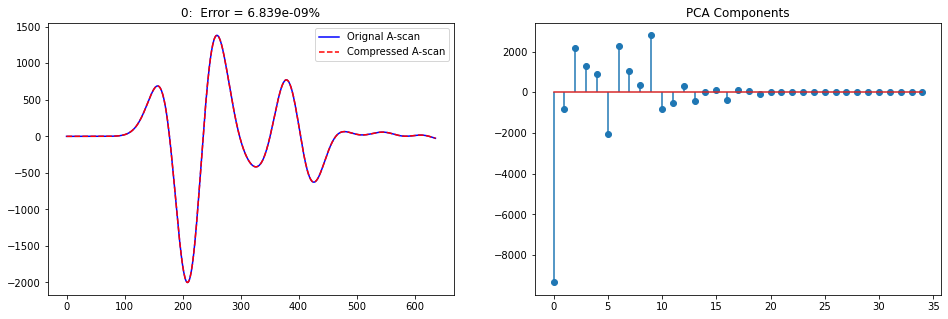

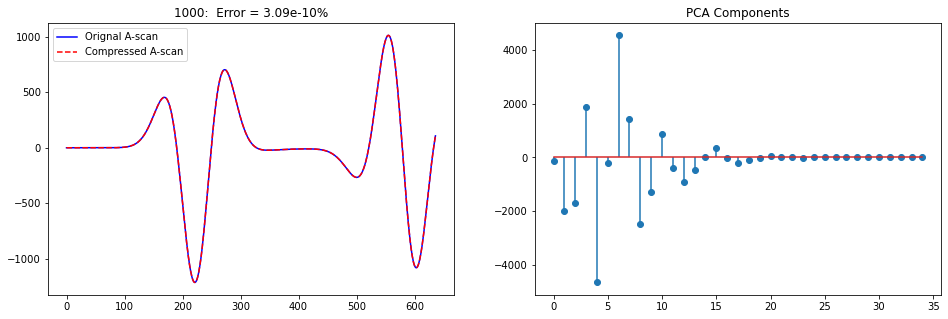

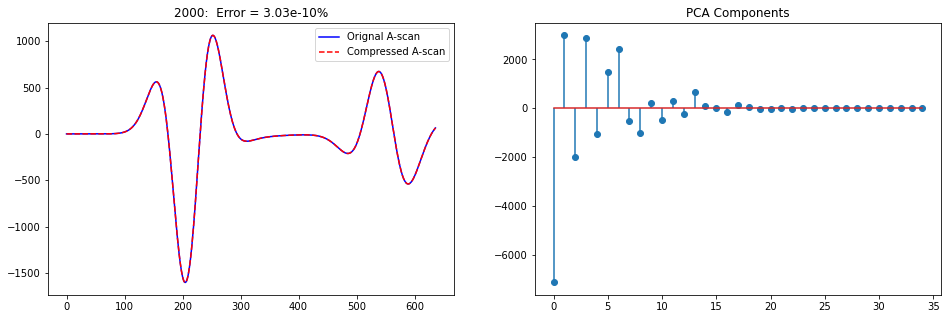

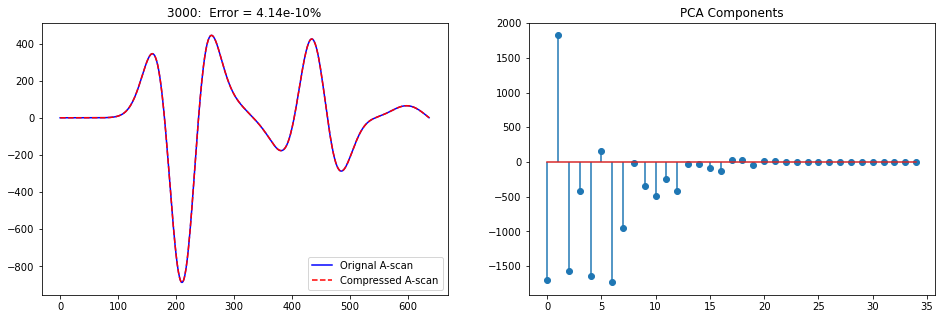

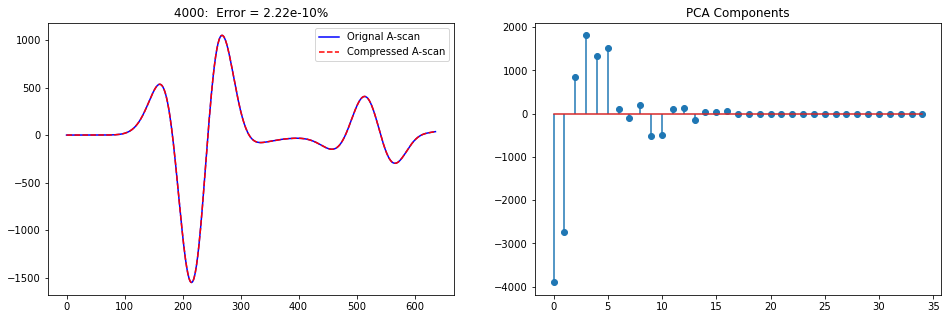

In [7]:
rec_y = pca.inverse_transform(train_y)

for i in range(0, train_y1.shape[0], 1000):

    A_scan = train_y1[i,:]
    comp_Ascan = train_y[i,:]
    rec_Ascan = rec_y[i,:]

    fig = plt.subplots(1,2, figsize=(16,5))
    plt.subplot(121)
    plt.title("{}:  Error = {}%".format(i, np.around(100 * nmse(A_scan, rec_Ascan), decimals=12)))
    plt.plot(A_scan, '-b', label='Orignal A-scan')
    plt.plot(rec_Ascan, '--r', label='Compressed A-scan')
    plt.legend()
    
    plt.subplot(122)
    plt.title("PCA Components")
    plt.stem(range(len(comp_Ascan)), comp_Ascan)
    plt.show()

We now have the training data ready for applying our ML scheme.

# Random Forest Regression

For starters, we use scikit-learn's `RandomForestRegressor`. The training was done after suitable hyper-parameter tuning.

In [8]:
from sklearn.ensemble import RandomForestRegressor
regr = RandomForestRegressor(max_depth=24).fit(train_x, train_y)

To test the performance of our ML model, we load another randomly generated dataset for the same gprMax scenario.

In [9]:
test_x = load_pkl_dat(path + "cylinder_Ascan_Test_{rand_params}_{compressed}.pkl")[0]
test_y = load_pkl_dat(path + "cylinder_Ascan_Test_{field_outputs}.pkl")[:,0,2,:]

print(test_x.shape)
print(test_y.shape)

(20, 17)
(20, 637)


Next, we apply the fitted regressor on our Test Dataset to predict the A-scans.

- `y_pred_compr` stores the compressed representation of the predicted A-scan
- `y_pred_final` stores the A-scan reconstructed from `y_pred_compr` (by computing the `inverse PCA transform`)

In [10]:
y_pred_compr = regr.predict(test_x)
y_pred_final = pca.inverse_transform(y_pred_compr)

print(y_pred_compr.shape)
print(y_pred_final.shape)

(20, 35)
(20, 637)


Batch Error = 0.123748425528181


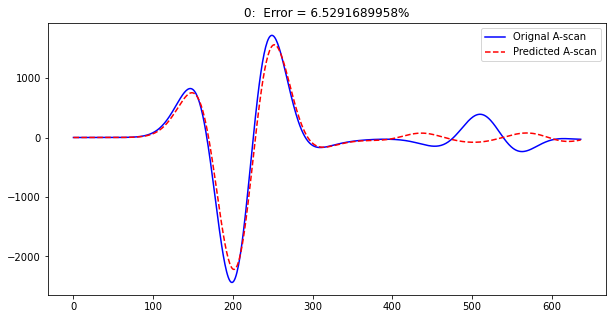

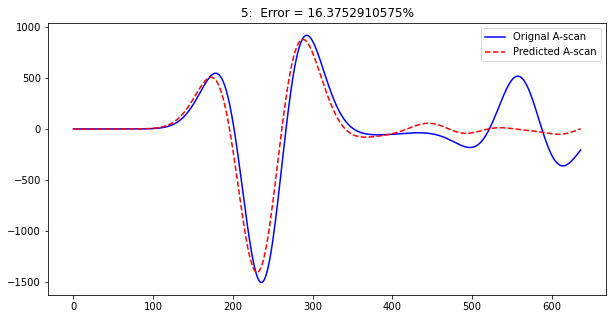

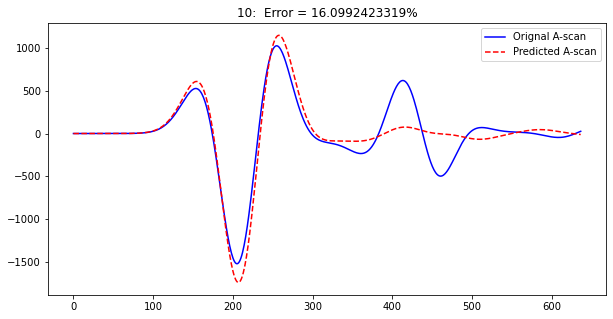

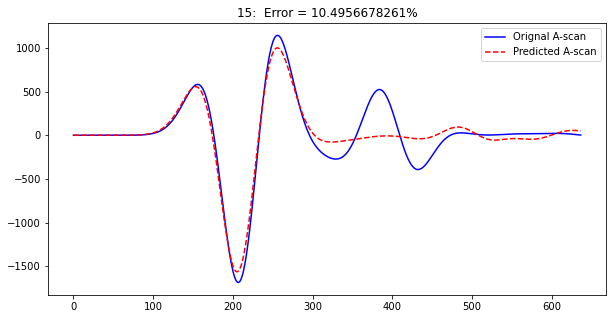

In [11]:
plot_pred_dat(test_y, y_pred_final, [], nmse)

# XGBoost

XGBoost only supports single output regression natively. For multi-output regression, we need to use scikit-learn's `MultiOutputRegressor` as a wrapper of `XGBRegressor`. 

`MultiOutputRegressor` trains one regressor per target and only requires that the regressor implements `fit` and `predict`, which `xgboost` happens to support [(further description)](https://stackoverflow.com/questions/39540123/muti-output-regression-in-xgboost) 

In [12]:
from sklearn.multioutput import MultiOutputRegressor
import xgboost as xgb

In [13]:
xg_reg = xgb.XGBRegressor(objective='reg:squarederror')
mult_xgb_regr = MultiOutputRegressor(xg_reg).fit(train_x, train_y)

/Users/utsavakhaury/opt/miniconda3/envs/gprMax/lib/python3.9/site-packages/xgboost/data.py:104: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


Batch Error = 0.10869192154821747


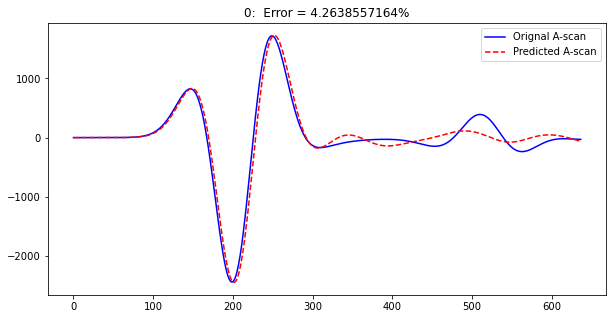

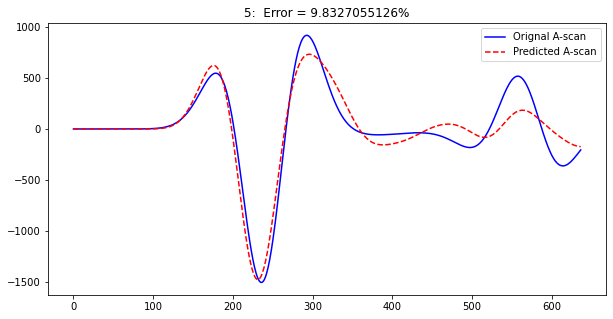

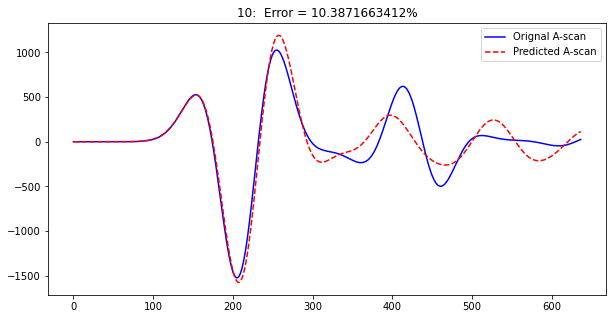

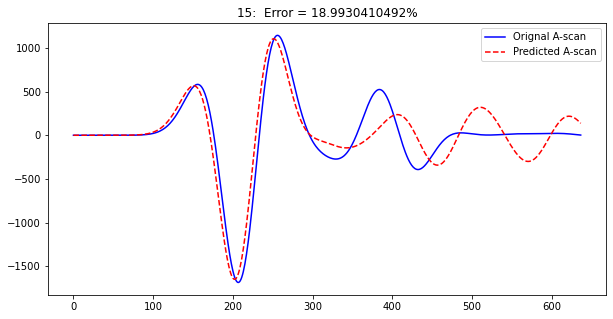

In [14]:
y_pred_compr = mult_xgb_regr.predict(test_x)
y_pred_final = pca.inverse_transform(y_pred_compr)

plot_pred_dat(test_y, y_pred_final, [], nmse)

# SVM Regression

In [15]:
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [16]:
svm_regr = make_pipeline(StandardScaler(), SVR(C=1.0, epsilon=0.2))
mult_svm_regr = MultiOutputRegressor(svm_regr).fit(train_x, train_y)

Batch Error = 0.6523209067334933


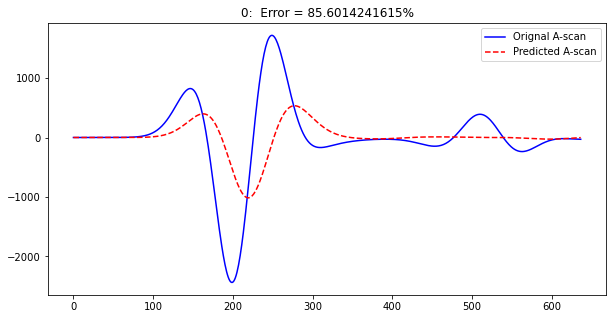

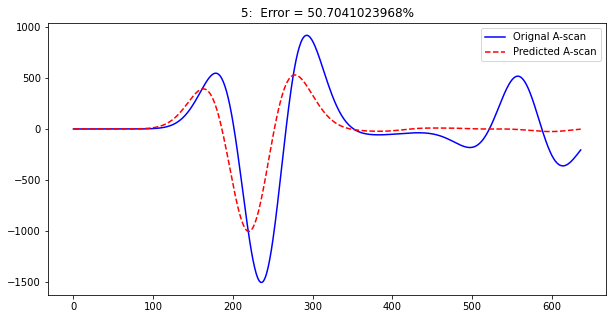

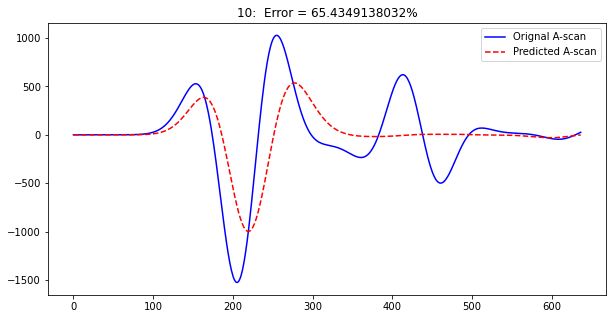

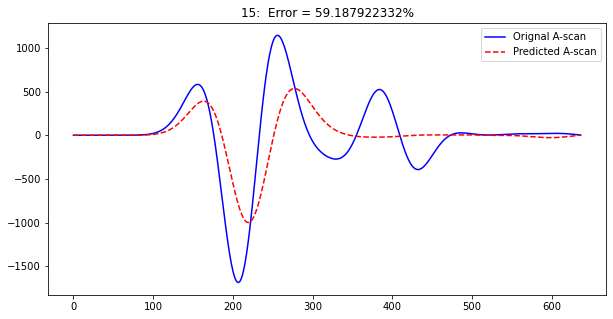

In [17]:
y_pred_compr = mult_svm_regr.predict(test_x)
y_pred_final = pca.inverse_transform(y_pred_compr)

plot_pred_dat(test_y, y_pred_final, [], nmse)

# SGDRegressor

In [18]:
from sklearn.linear_model import SGDRegressor

In [19]:
sgd_regr = make_pipeline(StandardScaler(), SGDRegressor(max_iter=1000, tol=1e-5))
mult_sgd_regr = MultiOutputRegressor(sgd_regr).fit(train_x, train_y)

Batch Error = 0.23676065100023846


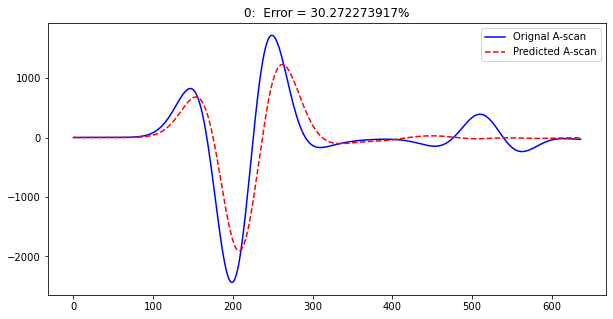

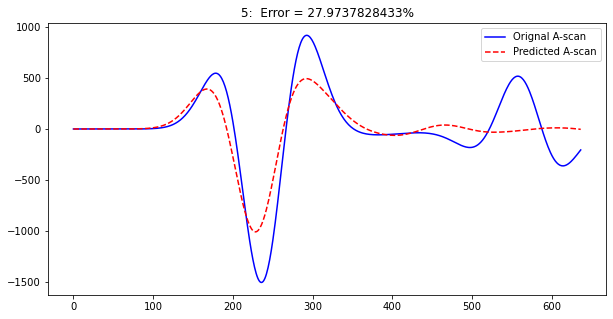

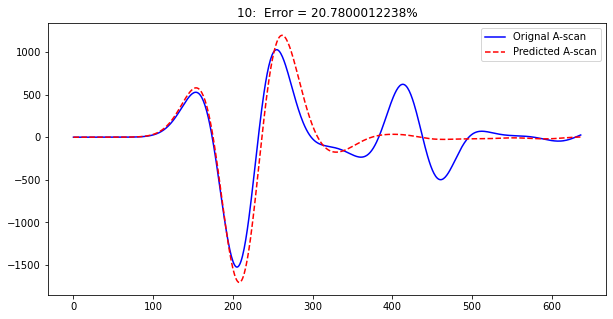

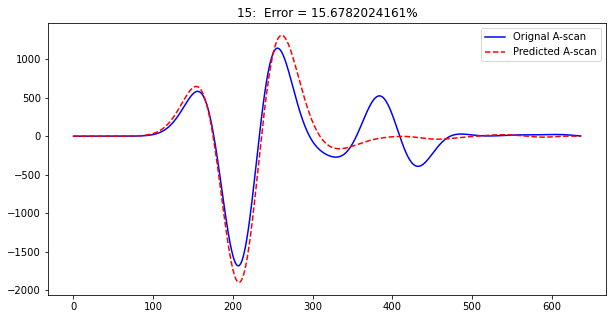

In [20]:
y_pred_compr = mult_sgd_regr.predict(test_x)
y_pred_final = pca.inverse_transform(y_pred_compr)

plot_pred_dat(test_y, y_pred_final, [], nmse)